In [1]:
%matplotlib inline

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # convert address to lat-long information

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# to get distance for k-means finalization
from scipy.spatial.distance import cdist

# import k-means 
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


# Creating Data

### Reading table with pandas

In [3]:
## we need to get canberra suburbs with postal codes 
## hence we need to get the table from https://postcodez.com.au/postcodes/act
## we scrap web to get it and have saved this at canberra_subrubs.csv
suburbs_df = pd.read_csv('canberra_suburbs.csv')
print(suburbs_df.shape)
suburbs_df.head(5)

(143, 2)


,Suburb,PostalCode
0,Aranda,2614
1,Belconnen,2617
2,Bruce,2617
3,Charnwood,2615
4,Cook,2614


### Looking for duplicates

In [4]:
suburbs_df.drop_duplicates(subset=['Suburb'], inplace=True)
print(suburbs_df.shape)

(140, 2)


#### Three duplicate entries

### Getting latitiude longitude for each suburb in  suburbs_df using geocoder

Data is stored in csv for reusability for making things run again and again without waiting for long

In [5]:
latlong_df = pd.read_csv('canberra_suburbs_lat_long.csv')
print(latlong_df.shape, latlong_df.columns)
## Removing duplicates
latlong_df.drop_duplicates(subset=['Suburb'], inplace=True)
print(latlong_df.shape)
## Removing rows with no lat long information
latlong_df.dropna(inplace=True)
print(latlong_df.shape)
latlong_df.head()


(140, 3) Index(['Suburb', 'Latitude', 'Longitude'], dtype='object')
(138, 3)
(137, 3)


,Suburb,Latitude,Longitude
0,Aranda,-35.25662,149.07967
1,Belconnen,-35.23934,149.06822
2,Bruce,-35.24245,149.07826
3,Charnwood,-35.20536,149.03225
4,Cook,-35.25905,149.06393


#### Two duplicate entries found and One ssuburb with no lat,long info

### Combining suburb data frame with postcode and lat long information

In [6]:
df = suburbs_df.join(latlong_df.set_index('Suburb'), on='Suburb')
print(df.shape)
## Removing rows with no lat,long information
df.dropna(inplace=True)
print(df.shape)
df.head()

(140, 4)
(137, 4)


,Suburb,PostalCode,Latitude,Longitude
0,Aranda,2614,-35.25662,149.07967
1,Belconnen,2617,-35.23934,149.06822
2,Bruce,2617,-35.24245,149.07826
3,Charnwood,2615,-35.20536,149.03225
4,Cook,2614,-35.25905,149.06393


### Lets get latitiude longitude of Canberra

In [7]:
address = 'Canberra, Australia'
geolocator = Nominatim(user_agent="canberra_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of canberra are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of canberra are -35.2975906, 149.1012676.


### Map of Canberra

In [8]:
# create map of canberra  using latitude and longitude values
map_canberra = folium.Map(location=[latitude, longitude], zoom_start=11.45)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Suburb']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canberra)  
    
map_canberra

**Inserting map pic so that it can be displayed on github**
![unclustered_image](Canberra_Suburbs.png)

**Setting FourSquare credentials to access neighbourhood data**

In [9]:
CLIENT_ID = 'ZNRSJ5SVENIWNCZFIL24Y4VSY5NWP5GDLFVZGCUNWIWQHJXK' # your Foursquare ID
CLIENT_SECRET = 'CLWZ3ISBB2JUQJYEY5NOBGY44GPLUX2MXT2EHCXQIIY3SA3V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZNRSJ5SVENIWNCZFIL24Y4VSY5NWP5GDLFVZGCUNWIWQHJXK
CLIENT_SECRET:CLWZ3ISBB2JUQJYEY5NOBGY44GPLUX2MXT2EHCXQIIY3SA3V


**Function to extract Suburb details for Canberra (use radius as 1.5 kms)**

In [10]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
canberra_venues = getNearbyVenues(names=df['Suburb'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

**Let's see how our dataframe looks like**

In [12]:
print(canberra_venues.shape)
canberra_venues.head()

(3294, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aranda,-35.25662,149.07967,Two Before Ten,-35.256406,149.078702,Café
1,Aranda,-35.25662,149.07967,Dumpling Inn,-35.252301,149.073685,Chinese Restaurant
2,Aranda,-35.25662,149.07967,Ricardo's Cafe,-35.253202,149.071270,Café
3,Aranda,-35.25662,149.07967,Little Oink,-35.259298,149.063540,Café
4,Aranda,-35.25662,149.07967,Turkish Pide House,-35.252340,149.073450,Middle Eastern Restaurant


#### Easily seen have extracted in total 3294 venues for all Suburbs

**venues per suburb**

In [13]:
canberra_venues.groupby('Suburb').count()

,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Suburb,,,,,,
Acton,100,100,100,100,100,100
Ainslie,39,39,39,39,39,39
Amaroo,9,9,9,9,9,9
Aranda,21,21,21,21,21,21
Banks,4,4,4,4,4,4
...,...,...,...,...,...,...
Weetangera,23,23,23,23,23,23
Weston,19,19,19,19,19,19
Weston Creek,4,4,4,4,4,4


#### We have three suburbs who do not have any venues as we can see number dropped from 137 to 134

In [14]:
### Those three suburbs are
suburbs_no_venues = set(df['Suburb'].values) - set(canberra_venues.groupby('Suburb').count().index.values)
print(f'Suburbs with no venues are {suburbs_no_venues }')

Suburbs with no venues are {'Top Naas', 'Majura', 'Uriarra Forest'}


In [15]:
## Dropping this venues from df
df = df[~df['Suburb'].isin(suburbs_no_venues)]

In [16]:
# Function to make beautiful plots
def custom_plot(width=10, height=10):
    mpl.rc('axes.spines', right=False, top=False)
    mpl.rc('axes', labelsize=20)
    mpl.rc('xtick', labelsize=16, top=False)
    mpl.rc('xtick.minor', visible=False)
    mpl.rc('ytick', labelsize=16, right=False)
    mpl.rc('ytick.minor', visible=False)
    mpl.rc('savefig', bbox='tight', format='pdf')
    mpl.rc('figure', figsize=(width, height))
    mpl.rc('legend',fontsize=16)

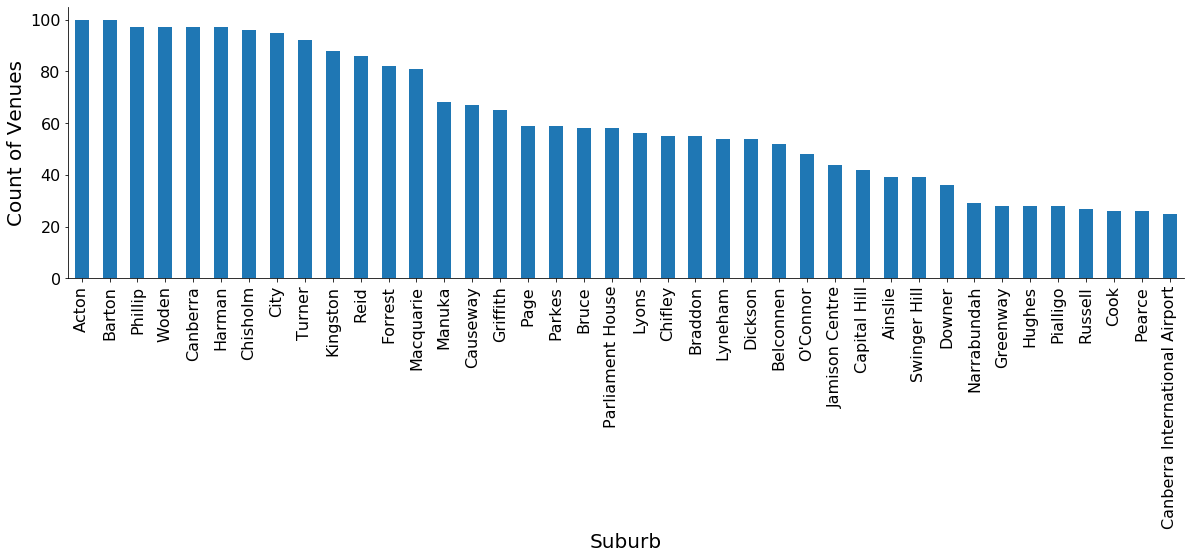

In [17]:
custom_plot(20,5)
fig = plt.figure()
ax = fig.add_subplot(111)
canberra_venues.groupby('Suburb').count()['Venue'].sort_values(ascending=False).head(40).plot(kind='bar', ax=ax)
ax.set_ylabel('Count of Venues')
plt.savefig('Canberra_Suburb_Venues.png')

### Let's make a dataframe that uses categories of venues as features in one hot encoding

In [18]:
# one hot encoding
canberra_onehot = pd.get_dummies(canberra_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
canberra_onehot['Suburb'] = canberra_venues['Suburb'] 
# move neighborhood column to the first column
neighborhood_index = canberra_onehot.columns.tolist().index('Suburb')
fixed_columns = [canberra_onehot.columns[neighborhood_index]] + list(canberra_onehot.columns[:neighborhood_index]) + list(canberra_onehot.columns[neighborhood_index+1:])
canberra_onehot = canberra_onehot[fixed_columns]
canberra_onehot.head()

,Suburb,Airport,Airport Lounge,Airport Terminal,Animal Shelter,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Winery,Yoga Studio
0,Aranda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aranda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aranda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aranda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aranda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Size of the data
canberra_onehot.shape

(3294, 216)

#### We can see there are in total 216 different types of categories

### Group Suburbs by mean frequency of different categories

We are making features for each suburbs so that we can use it in our models

In [20]:
canberra_grouped = canberra_onehot.groupby('Suburb').mean().reset_index()
print(canberra_grouped.shape)
canberra_grouped.head()

(134, 216)


,Suburb,Airport,Airport Lounge,Airport Terminal,Animal Shelter,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Winery,Yoga Studio
0,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.000000,...,0.000000,0.0,0.0,0.010000,0.0,0.0,0.01,0.03,0.0,0.0
1,Ainslie,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.051282,...,0.025641,0.0,0.0,0.025641,0.0,0.0,0.00,0.00,0.0,0.0
2,Amaroo,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0
3,Aranda,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0
4,Banks,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0


In [21]:
# size of this data
canberra_grouped.shape

(134, 216)

### Lets get features of each suburb as frequency of top 15 categories in each suburb

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = canberra_grouped['Suburb']

for ind in np.arange(canberra_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(canberra_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Acton,Café,Coffee Shop,Food Truck,Wine Bar,Hotel,Italian Restaurant,Restaurant,Plaza,Steakhouse,Multiplex,Thai Restaurant,Korean Restaurant,Burger Joint,Japanese Restaurant,Asian Restaurant
1,Ainslie,Café,Grocery Store,Hotel,Pub,Bakery,Mountain,Australian Restaurant,Scenic Lookout,Social Club,Shopping Plaza,Flower Shop,Business Service,Cupcake Shop,Gas Station,Fast Food Restaurant
2,Amaroo,Grocery Store,Indian Restaurant,Lake,Bar,Chinese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Fast Food Restaurant,Food Court,Food & Drink Shop,Fish & Chips Shop,Flower Shop,Food Truck,Flea Market,Fountain
3,Aranda,Café,Supermarket,Newsstand,Bar,Bakery,Chinese Restaurant,Coffee Shop,Sports Bar,Tennis Court,Burger Joint,Gym,Middle Eastern Restaurant,Liquor Store,Donut Shop,Nature Preserve
4,Banks,Mountain,Pizza Place,Trail,Grocery Store,Farmers Market,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant


## Find optimal number of Clusters for dividing Canberra

Now we have features for each suburb

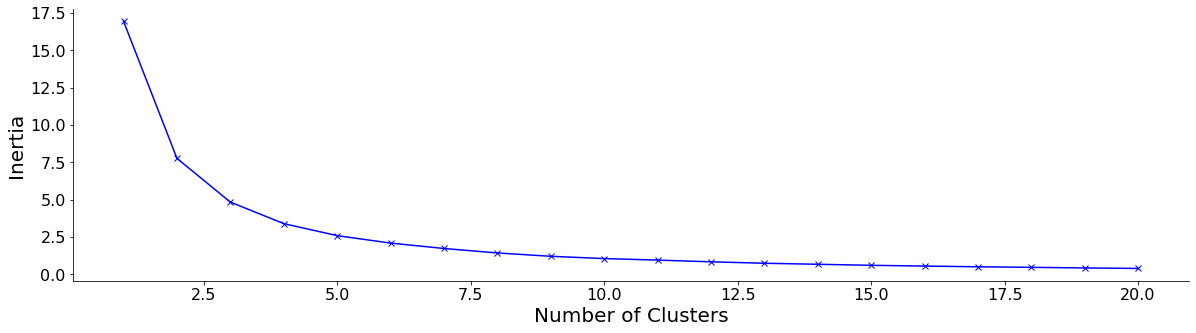

In [23]:
canberra_grouped_clustering = canberra_grouped.drop('Suburb', 1)
inertia = []
K = range(1,21)
for k in K:
    model = KMeans(n_clusters=k, random_state=0).fit(canberra_grouped_clustering)
    # sklearn gives a metric to evaluate how good each clustring is
    inertia.append(model.inertia_/k)

# Plot inertia and loof for elbow
custom_plot(20,5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, inertia, 'bx-')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
plt.savefig('Canberra_cluster_numbers.png')

## We can see from above graph we need to cluster suburbs into 10 different groups



In [24]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(canberra_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 3, 1, 3, 1, 9, 1, 4, 1], dtype=int32)

### Adding cluster labels for neighborhood

In [25]:
# add clustering labels
suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

canberra_merged = df

# merge canberra_grouped with canberra_data to add latitude/longitude for each neighborhood
canberra_merged = canberra_merged.join(suburbs_venues_sorted.set_index('Suburb'), on='Suburb')

canberra_merged.head() # check the last columns!

,Suburb,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Aranda,2614,-35.25662,149.07967,1,Café,Supermarket,Newsstand,Bar,Bakery,Chinese Restaurant,Coffee Shop,Sports Bar,Tennis Court,Burger Joint,Gym,Middle Eastern Restaurant,Liquor Store,Donut Shop,Nature Preserve
1,Belconnen,2617,-35.23934,149.06822,1,Café,Liquor Store,Gym,Burrito Place,Bookstore,Electronics Store,Music Venue,Coffee Shop,Sandwich Place,Shopping Mall,Supermarket,Sports Bar,Malay Restaurant,Frozen Yogurt Shop,Burger Joint
2,Bruce,2617,-35.24245,149.07826,1,Café,Gym,Burrito Place,Coffee Shop,Liquor Store,Chinese Restaurant,Sandwich Place,Supermarket,Electronics Store,Bookstore,Burger Joint,Multiplex,Music Venue,Fruit & Vegetable Store,Frozen Yogurt Shop
3,Charnwood,2615,-35.20536,149.03225,7,Supermarket,Fried Chicken Joint,Convenience Store,Middle Eastern Restaurant,Shopping Plaza,Gas Station,Seafood Restaurant,Donut Shop,Dry Cleaner,Food Court,Food & Drink Shop,Dim Sum Restaurant,Flower Shop,Flea Market,Diner
4,Cook,2614,-35.25905,149.06393,4,Café,Food & Drink Shop,Supermarket,Bakery,Bar,Burger Joint,Middle Eastern Restaurant,Chinese Restaurant,Sports Bar,Coffee Shop,Liquor Store,Newsstand,Tennis Court,Thrift / Vintage Store,Pizza Place


## Map for canberra neighborhoods as per our clustering

In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.45)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(canberra_merged['Latitude'], canberra_merged['Longitude'], canberra_merged['Suburb'], canberra_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Inserting map pic so that it can be displayed on github**
![unclustered_image](Canberra_Suburbs_clusters.png)

## Now using price infomration availble at https://sqmresearch.com.au/weekly-rents.php? which is stored here canberra_suburbs_proces.csv

In [27]:
canberra_prices = pd.read_csv('canberra_suburbs_prices.csv')
canberra_merged = canberra_merged.join(canberra_prices.set_index('Suburb'), on='Suburb')
canberra_merged.dropna(inplace=True)
print(canberra_merged.shape)
canberra_merged.head()

(132, 21)


,Suburb,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,Prices
0,Aranda,2614,-35.25662,149.07967,1,Café,Supermarket,Newsstand,Bar,Bakery,...,Coffee Shop,Sports Bar,Tennis Court,Burger Joint,Gym,Middle Eastern Restaurant,Liquor Store,Donut Shop,Nature Preserve,449.5
1,Belconnen,2617,-35.23934,149.06822,1,Café,Liquor Store,Gym,Burrito Place,Bookstore,...,Music Venue,Coffee Shop,Sandwich Place,Shopping Mall,Supermarket,Sports Bar,Malay Restaurant,Frozen Yogurt Shop,Burger Joint,470.7
2,Bruce,2617,-35.24245,149.07826,1,Café,Gym,Burrito Place,Coffee Shop,Liquor Store,...,Sandwich Place,Supermarket,Electronics Store,Bookstore,Burger Joint,Multiplex,Music Venue,Fruit & Vegetable Store,Frozen Yogurt Shop,470.7
3,Charnwood,2615,-35.20536,149.03225,7,Supermarket,Fried Chicken Joint,Convenience Store,Middle Eastern Restaurant,Shopping Plaza,...,Seafood Restaurant,Donut Shop,Dry Cleaner,Food Court,Food & Drink Shop,Dim Sum Restaurant,Flower Shop,Flea Market,Diner,409.0
4,Cook,2614,-35.25905,149.06393,4,Café,Food & Drink Shop,Supermarket,Bakery,Bar,...,Middle Eastern Restaurant,Chinese Restaurant,Sports Bar,Coffee Shop,Liquor Store,Newsstand,Tennis Court,Thrift / Vintage Store,Pizza Place,449.5


# Get what are the 5 top Venues for each cluster

In [28]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==0]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Kowen Forest,-35.319632,Racetrack,Rental Car Location,Nature Preserve,Exhibit,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Event Space
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [29]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==1]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54
unique,54,51,7,25,30,37,38,37,34,36,40,34,33,38,36,36,43
top,Forrest,-35.279552,Café,Hotel,Park,Hotel,Wine Bar,Italian Restaurant,Restaurant,Food Truck,Electronics Store,Japanese Restaurant,Restaurant,Fish Market,Grocery Store,Steakhouse,Fish & Chips Shop
freq,1,4,43,8,8,5,5,7,5,5,5,5,5,5,6,5,4


In [30]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==2]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
unique,6,6,5,4,4,4,3,3,3,2,2,2,2,2,2,2,2
top,Lawson,-35.171256,Grocery Store,Supermarket,Shopping Mall,Grocery Store,Yoga Studio,Farmers Market,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant
freq,1,1,2,2,2,3,3,4,4,4,4,4,4,4,4,4,4


In [31]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==3]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
unique,14,14,9,12,11,6,9,8,7,6,4,4,4,4,5,5,5
top,Crace,-35.201251,Grocery Store,Home Service,Construction & Landscaping,Grocery Store,Farmers Market,Fountain,Food Truck,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
freq,2,2,4,2,3,7,4,5,6,6,8,8,7,7,7,7,7


In [32]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==4]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34
unique,34,34,23,22,29,26,25,29,25,26,24,22,18,21,20,20,18
top,Kambah,-35.321618,Café,Café,Indian Restaurant,Café,Yoga Studio,Grocery Store,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant
freq,1,1,5,5,3,3,4,3,6,7,8,8,9,8,9,8,7


In [33]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==5]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Pierces Creek,-35.343976,Park,Yoga Studio,Farmers Market,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Exhibit
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [34]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==6]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Mount Stromlo,-35.32564,Planetarium,Café,Yoga Studio,Fast Food Restaurant,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Farmers Market
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [35]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==7]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
unique,18,18,9,8,14,13,13,9,13,13,12,12,11,13,8,8,8
top,Macgregor,-35.207233,Sports Bar,Sports Bar,Fast Food Restaurant,Chinese Restaurant,Coffee Shop,Café,Grocery Store,Convenience Store,Supermarket,Supermarket,Flower Shop,Fish & Chips Shop,Fish Market,Filipino Restaurant,Flea Market
freq,1,1,4,6,3,4,3,3,3,4,3,3,3,2,6,4,4


In [36]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==8]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Tharwa,-35.508695,Shop & Service,Yoga Studio,Fast Food Restaurant,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Filipino Restaurant,Farmers Market,Department Store
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [39]:
df_0 = canberra_merged[canberra_merged['Cluster Labels']==9]
df_0.describe(include=[np.object])

,Suburb,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
count,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Looking at data we can see best place for a new comer  with kids to live should be in cluster with id 2,3,7,4 with respect to amenities

In [44]:
canberra_merged[canberra_merged['Cluster Labels']==2]['Prices'].describe()

count      6.000000
mean     451.100000
std       23.055412
min      407.700000
25%      452.500000
50%      452.500000
75%      466.150000
max      470.700000
Name: Prices, dtype: float64

In [47]:
canberra_merged[canberra_merged['Cluster Labels']==3]['Prices'].describe()

count     16.00000
mean     453.30000
std       40.66512
min      409.00000
25%      426.30000
50%      460.10000
75%      462.75000
max      579.10000
Name: Prices, dtype: float64

In [46]:
canberra_merged[canberra_merged['Cluster Labels']==7]['Prices'].describe()

count     18.000000
mean     452.733333
std       73.796644
min      409.000000
25%      409.000000
50%      428.900000
75%      452.500000
max      645.700000
Name: Prices, dtype: float64

In [45]:
canberra_merged[canberra_merged['Cluster Labels']==4]['Prices'].describe()

count      34.000000
mean      555.764706
std       717.537481
min       260.000000
25%       409.000000
50%       428.900000
75%       449.500000
max      4601.000000
Name: Prices, dtype: float64

# Based on rent it seems area with cluster id 2 is best suited as it has lowest mean

In [60]:
# create map
best_area = folium.Map(location=[latitude, longitude], zoom_start=11.45)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(canberra_merged[canberra_merged['Cluster Labels']==2]['Latitude'], canberra_merged[canberra_merged['Cluster Labels']==2]['Longitude'], canberra_merged[canberra_merged['Cluster Labels']==2]['Suburb'], canberra_merged[canberra_merged['Cluster Labels']==2]['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    print(poi)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(best_area)
       
best_area

Giralang
Kaleen
Lawson
Casey
Ngunnawal
Palmerston


**Inserting map pic so that it can be displayed on github**
![unclustered_image](Canberra_Suburb_best.png)